In [23]:
# import packages for initial exploration
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json

import os

import sklearn as sk

In [2]:
# load in the training dataframe
train = pd.read_csv('datasets/train.csv')
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### We are trying to predict Survived and everything else can be treated as data (besides the PassengerId)

In [19]:
# let's see overall rate of nulls
null_rate = train.isna().sum() / train.shape[0]
null_rate.sort_values(ascending=False)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
Fare           0.000000
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
Survived       0.000000
PassengerId    0.000000
dtype: float64

In [20]:
# Cabin is primarily null, what are its unique values?
train['Cabin'].nunique()

147

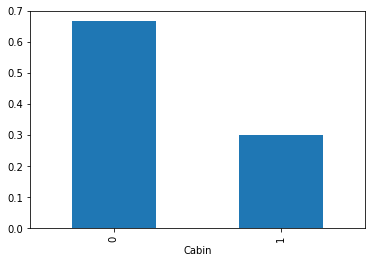

In [22]:
# there are way too many unique values - is there a difference for nulls for Survived?
train.groupby(train['Cabin'].isna().astype(int))['Survived'].mean().plot(kind='bar')

In [15]:
# makes a huge difference in survival rate! If there was a Cabin assigned, survival was 66% vs 30% for non-Cabin
# does it matter how many values the Cabin string has?
train['Cabin'].str.split(' ').str.len().apply(lambda x: 0 if pd.isna(x) else x).value_counts()

0.0    687
1.0    180
2.0     16
3.0      6
4.0      2
Name: Cabin, dtype: int64

In [29]:
# seems like Cabin can be turned into a simple 0/1 for null/non-null becasuse values > 1 are rare
class NullBinaryTransformer(sk.base.BaseEstimator, sk.base.TransformerMixin):
    def __init__(self, variables: list):
        self.variables = variables
    def fit(self, X=None, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.variables].isna().astype(int)

In [41]:
# what about Age?
train.groupby(train['Age'].isna().astype(int))['Survived'].mean()

Age
0    0.406162
1    0.293785
Name: Survived, dtype: float64

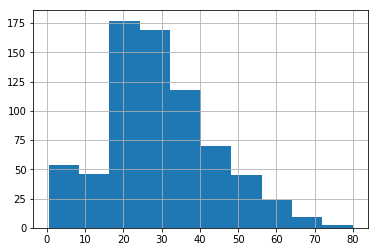

In [43]:
# null shows power in splitting our binary target - what about a more general population idea?
train['Age'].hist()
plt.show()

In [44]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

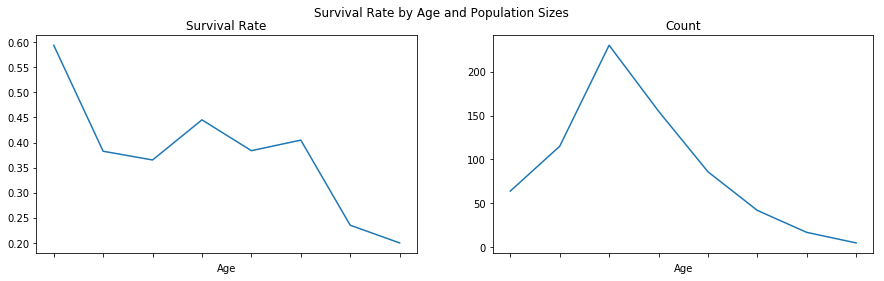

In [58]:
# what about survival rate in terms of bins of age 10?
age_bins = np.arange(start=0, stop=81, step=10)
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 4))
ax = ax.flatten()
plot_g = train.groupby(pd.cut(x=train['Age'], bins=age_bins, right=True, include_lowest=True))['Survived']
plot_g.mean().plot(ax=ax[0])
ax[0].set_title('Survival Rate')
plot_g.count().plot(ax=ax[1])
ax[1].set_title('Count')
fig.suptitle('Survival Rate by Age and Population Sizes')
plt.show()

In [ ]:
# as population size decreases so does the confidence in the survival rate
# intuitively it makes sense that kids would be prioritized over everyone
# there are several ways to treat this variable, the null surival rate is about that of Age 65